<a href="https://colab.research.google.com/github/carlosvalenciano/Project4/blob/main/Multiple_Stock_Market_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
#!pip install yahoo_fin

In [1]:
import numpy as np
import time as tm
import datetime as dt
import tensorflow as tf
import pandas as pd

# Data preparation
#from yahoo_fin import stock_info as yf
from sklearn.preprocessing import MinMaxScaler
from collections import deque

import yfinance as yf
from pandas_datareader import data as pdr
yf.pdr_override()

# AI
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# For time stamps
from datetime import datetime

# Graphics library
import matplotlib.pyplot as plt

In [4]:
# SETTINGS

# Window size or the sequence length, 7 (1 week)
N_STEPS = 7

# Lookup steps, 1 is the next day, 3 = day after tomorrow
LOOKUP_STEPS = [1, 2, 3]

# The tech stocks we'll use for this analysis
stocks = ['AAPL', 'GOOG', 'MSFT', 'AMZN', 'META']

# Set up End and Start times for data grab
end = datetime.now()
start = datetime(end.year - 4, end.month, end.day)


#For loop for grabing yahoo finance data and setting as a dataframe
for ticker in stocks:
    # Set DataFrame as the Stock Ticker
    globals()[ticker] = yf.download(ticker, start, end)


# Current date
#date_now = tm.strftime('%Y-%m-%d')
#date_3_years_back = (dt.date.today() - dt.timedelta(days=1104)).strftime('%Y-%m-%d')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [5]:
company_ticker = [AAPL, GOOG, MSFT, AMZN, META]
company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON", "META"]

for company, com_name in zip(company_ticker, company_name):
    company["company_name"] = com_name

df = pd.concat(company_ticker, axis=0)
df

Open        High         Low       Close   Adj Close  \
Date                                                                     
2019-12-12   66.945000   68.139999   66.830002   67.864998   66.116249   
2019-12-13   67.864998   68.824997   67.732498   68.787498   67.014992   
2019-12-16   69.250000   70.197502   69.245003   69.964996   68.162148   
2019-12-17   69.892502   70.442497   69.699997   70.102501   68.296104   
2019-12-18   69.949997   70.474998   69.779999   69.934998   68.132904   
...                ...         ...         ...         ...         ...   
2023-12-05  318.980011  321.880005  315.390015  318.290009  318.290009   
2023-12-06  321.929993  322.250000  317.040009  317.450012  317.450012   
2023-12-07  317.769989  328.239990  317.769989  326.589996  326.589996   
2023-12-08  323.089996  333.170013  323.000000  332.750000  332.750000   
2023-12-11  329.399994  329.890015  320.000000  325.279999  325.279999   

               Volume company_name  
Date                                
2019-12-12  137310400        APPLE  
2019-12-13  133587600        APPLE  
2019-12-16  128186000        APPLE  
2019-12-17  114158400        APPLE  
2019-12-18  116028400        APPLE  
...               ...          ...  
2023-12-05   16952100         META  
2023-12-06   11294300         META  
2023-12-07   15905100         META  
2023-12-08   14077500         META  
2023-12-11   25778700         META  

[5030 rows x 7 columns]

In [4]:
# remove columns which our neural network will not use
#df = df.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)

# create the column 'date' based on index column
#df['date'] = df.index
display(df)

Open        High         Low       Close   Adj Close  \
Date                                                                     
2022-12-12  142.699997  144.500000  141.059998  144.490005  143.686859   
2022-12-13  149.500000  149.970001  144.240005  145.470001  144.661423   
2022-12-14  145.350006  146.660004  141.160004  143.210007  142.413986   
2022-12-15  141.110001  141.800003  136.029999  136.500000  135.741272   
2022-12-16  136.690002  137.649994  133.729996  134.509995  133.762344   
...                ...         ...         ...         ...         ...   
2023-12-05  318.980011  321.880005  315.390015  318.290009  318.290009   
2023-12-06  321.929993  322.250000  317.040009  317.450012  317.450012   
2023-12-07  317.769989  328.239990  317.769989  326.589996  326.589996   
2023-12-08  323.089996  333.170013  323.000000  332.750000  332.750000   
2023-12-11  329.399994  329.890015  319.994995  325.279999  325.279999   

               Volume company_name  
Date                                
2022-12-12   70462700        APPLE  
2022-12-13   93886200        APPLE  
2022-12-14   82291200        APPLE  
2022-12-15   98931900        APPLE  
2022-12-16  160156900        APPLE  
...               ...          ...  
2023-12-05   16952100         META  
2023-12-06   11294300         META  
2023-12-07   15905100         META  
2023-12-08   14077500         META  
2023-12-11   25463704         META  

[1255 rows x 7 columns]

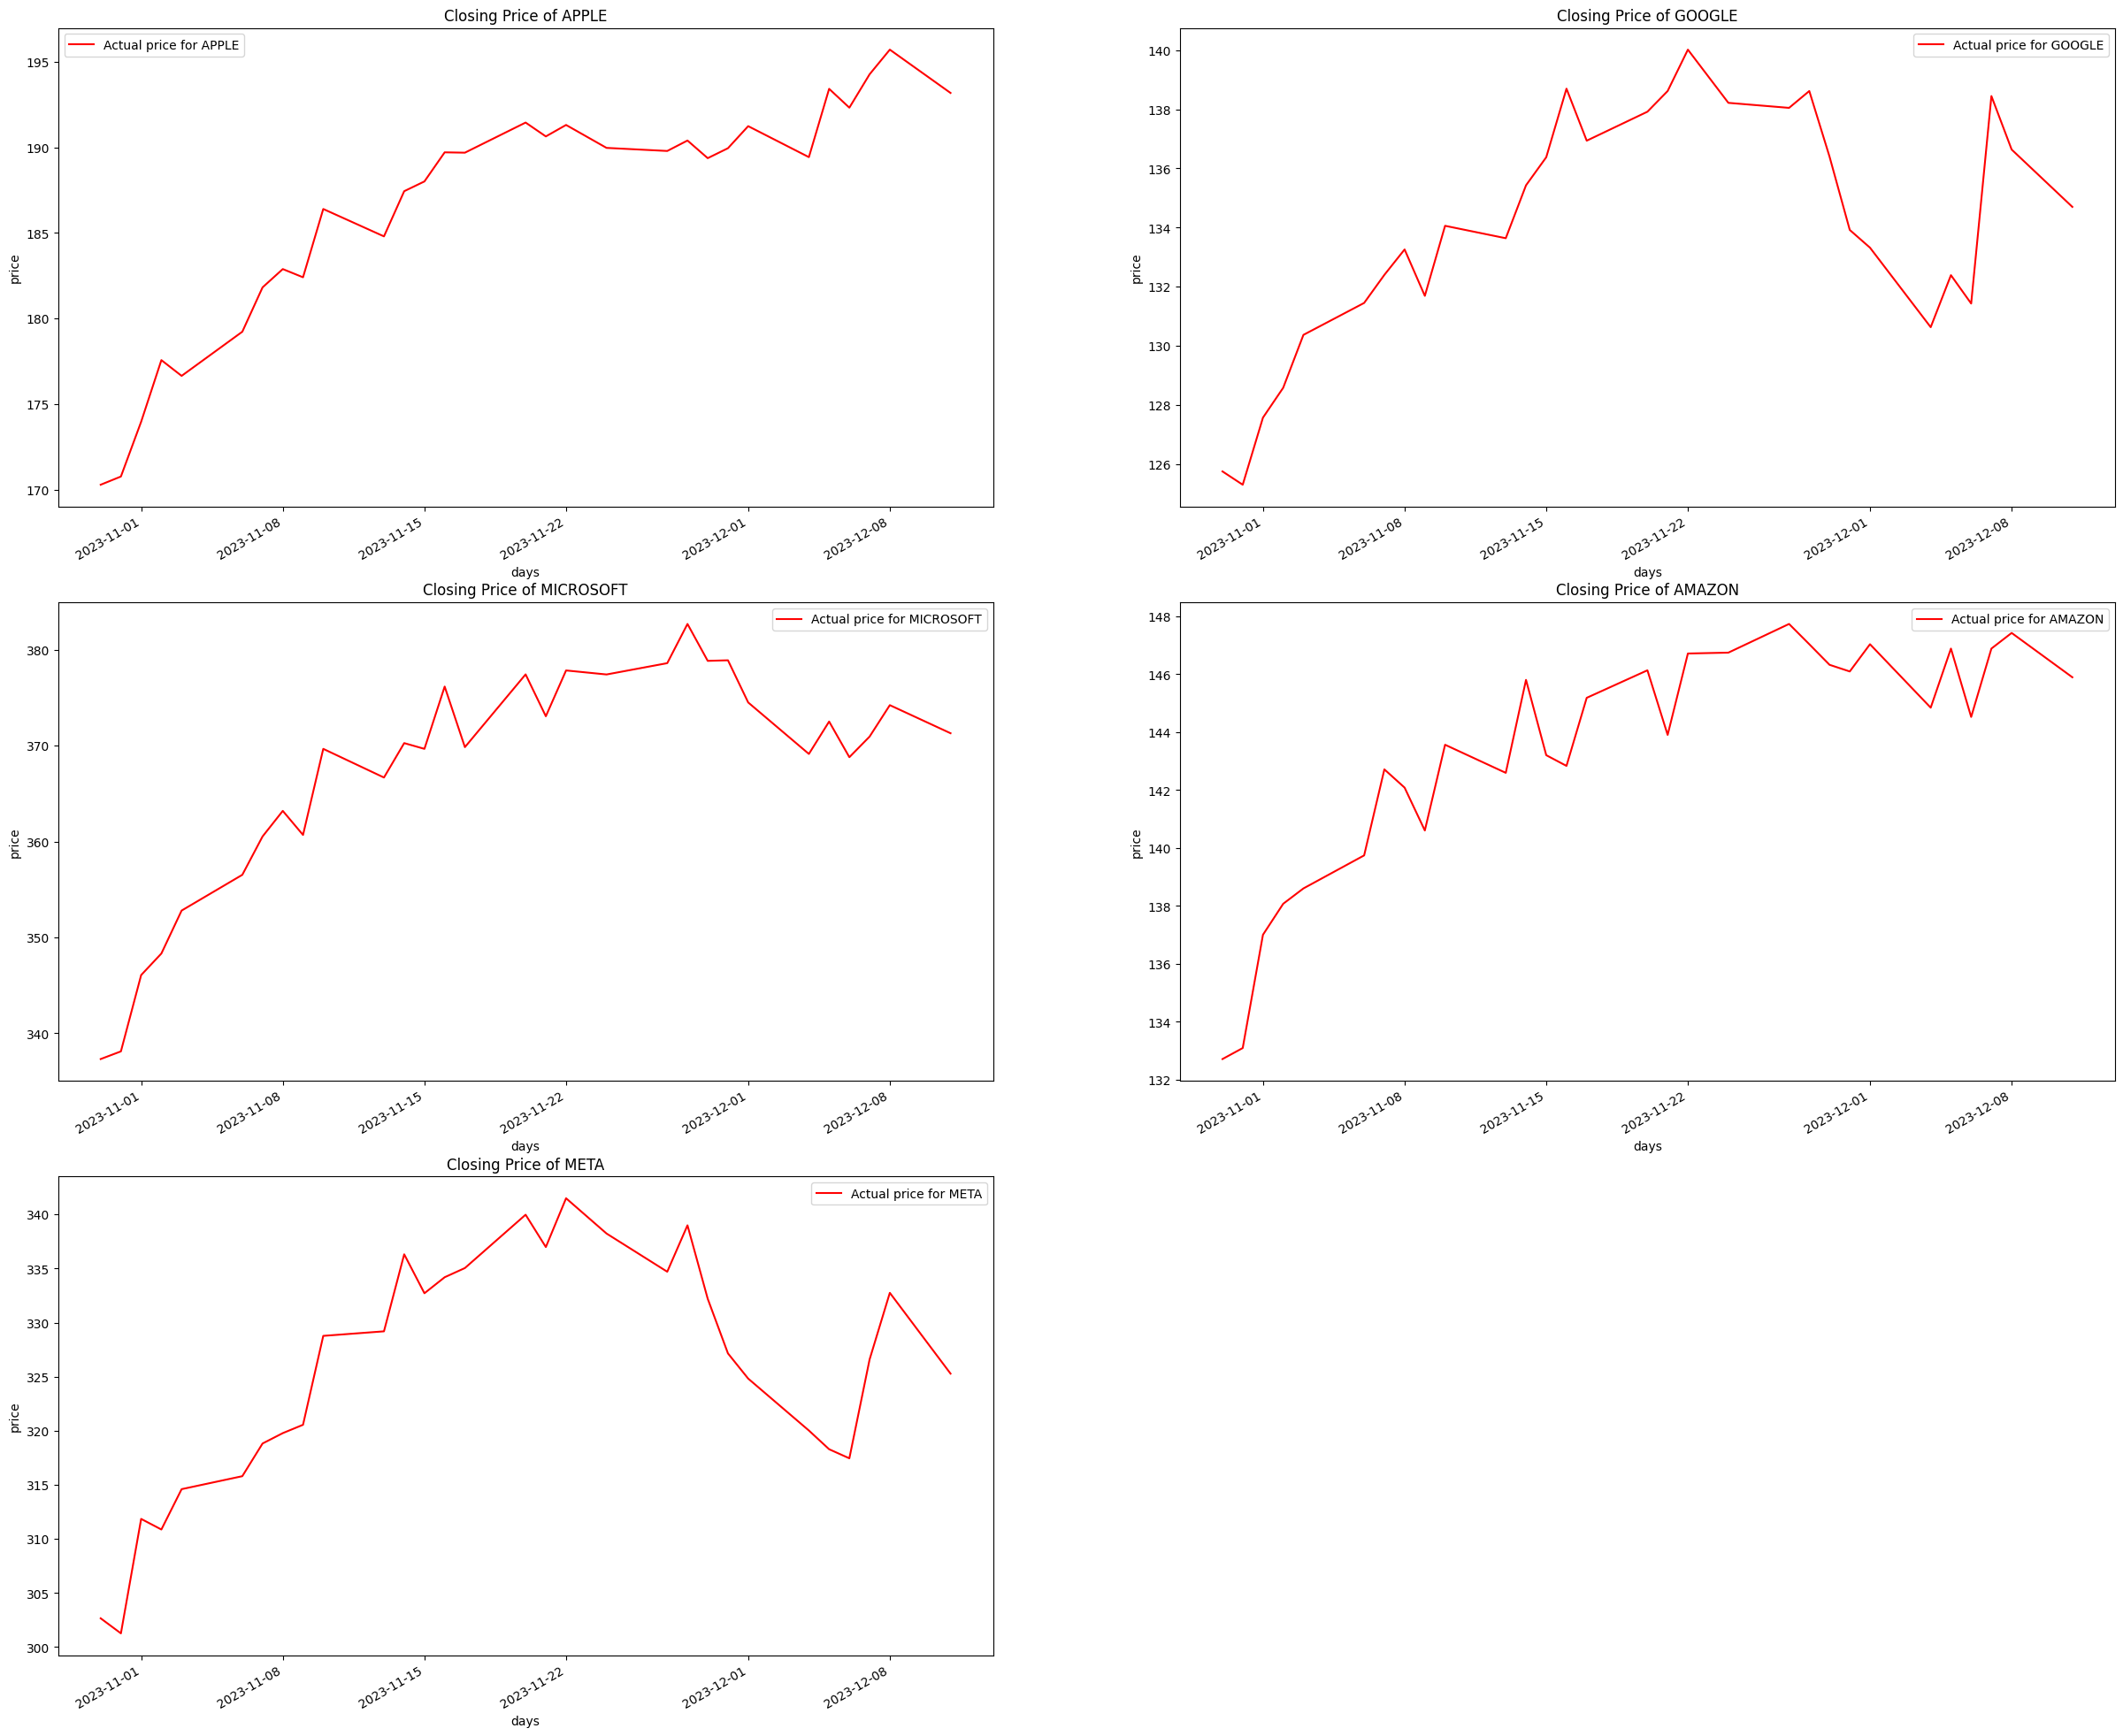

In [6]:
plt.figure(figsize=(30, 8))
plt.subplots_adjust(top=2.5, bottom=1.2)

for i, company in enumerate(company_ticker, 1):
  plt.subplot(3, 2, i)
  company['Close'][-30:].plot(color='r')
  plt.xlabel("days")
  plt.ylabel("price")
  plt.title(f'Closing Price of {company_name[i-1]}')
  plt.legend([f'Actual price for {company_name[i-1]}'])

In [7]:
# Scale data for ML engine
scaler = MinMaxScaler()
df['Scaled_Close'] = scaler.fit_transform(np.expand_dims(df['Close'].values, axis=1))
display(df)

Open        High         Low       Close   Adj Close  \
Date                                                                     
2019-12-12   66.945000   68.139999   66.830002   67.864998   66.116249   
2019-12-13   67.864998   68.824997   67.732498   68.787498   67.014992   
2019-12-16   69.250000   70.197502   69.245003   69.964996   68.162148   
2019-12-17   69.892502   70.442497   69.699997   70.102501   68.296104   
2019-12-18   69.949997   70.474998   69.779999   69.934998   68.132904   
...                ...         ...         ...         ...         ...   
2023-12-05  318.980011  321.880005  315.390015  318.290009  318.290009   
2023-12-06  321.929993  322.250000  317.040009  317.450012  317.450012   
2023-12-07  317.769989  328.239990  317.769989  326.589996  326.589996   
2023-12-08  323.089996  333.170013  323.000000  332.750000  332.750000   
2023-12-11  329.399994  329.890015  320.000000  325.279999  325.279999   

               Volume company_name  Scaled_Close  
Date                                              
2019-12-12  137310400        APPLE      0.045576  
2019-12-13  133587600        APPLE      0.048372  
2019-12-16  128186000        APPLE      0.051942  
2019-12-17  114158400        APPLE      0.052359  
2019-12-18  116028400        APPLE      0.051851  
...               ...          ...           ...  
2023-12-05   16952100         META      0.804741  
2023-12-06   11294300         META      0.802194  
2023-12-07   15905100         META      0.829902  
2023-12-08   14077500         META      0.848576  
2023-12-11   25778700         META      0.825931  

[5030 rows x 8 columns]

In [8]:
def PrepareData(days):
  df2 = df.copy()
  df2['future'] = df2['Scaled_Close'].shift(-days)
  last_sequence = np.array(df2[['Scaled_Close']].tail(days))
  df2.dropna(inplace=True)
  sequence_data = []
  sequences = deque(maxlen=N_STEPS)

  for entry, target in zip(df2[['Scaled_Close'] + ['Date']].values, df2['future'].values):
      sequences.append(entry)
      if len(sequences) == N_STEPS:
          sequence_data.append([np.array(sequences), target])

  last_sequence = list([s[:len(['Scaled_Close'])] for s in sequences]) + list(last_sequence)
  last_sequence = np.array(last_sequence).astype(np.float32)

  # construct the X's and Y's
  X, Y = [], []
  for seq, target in sequence_data:
      X.append(seq)
      Y.append(target)

  # convert to numpy arrays
  X = np.array(X)
  Y = np.array(Y)

  return df, last_sequence, X, Y

In [9]:
def GetTrainedModel(x_train, y_train):
  model = Sequential()
  model.add(LSTM(60, return_sequences=True, input_shape=(N_STEPS, len(['Scaled_Close']))))
  model.add(Dropout(0.3))
  model.add(LSTM(120, return_sequences=False))
  model.add(Dropout(0.3))
  model.add(Dense(20))
  model.add(Dense(1))

  BATCH_SIZE = 128
  EPOCHS = 80

  model.compile(loss='mean_squared_error', optimizer='adam')

  model.fit(x_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            verbose=1)

  model.summary()

  return model

In [10]:
# create the column 'date' based on index column
df['Date'] = df.index

In [11]:
# GET PREDICTIONS
predictions = []

for step in LOOKUP_STEPS:
  df2, last_sequence, x_train, y_train = PrepareData(step)
  x_train = x_train[:, :, :len(['Scaled_Close'])].astype(np.float32)

  model = GetTrainedModel(x_train, y_train)

  last_sequence = last_sequence[-N_STEPS:]
  last_sequence = np.expand_dims(last_sequence, axis=0)
  prediction = model.predict(last_sequence)
  predicted_price = scaler.inverse_transform(prediction)[0][0]

  predictions.append(round(float(predicted_price), 2))

Epoch 1/80
40/40 [==============================] - 7s 74ms/step - loss: 0.0202
Epoch 2/80
40/40 [==============================] - 2s 48ms/step - loss: 0.0031
Epoch 3/80
40/40 [==============================] - 1s 31ms/step - loss: 0.0026
Epoch 4/80
40/40 [==============================] - 1s 33ms/step - loss: 0.0023
Epoch 5/80
40/40 [==============================] - 2s 44ms/step - loss: 0.0022
Epoch 6/80
40/40 [==============================] - 1s 31ms/step - loss: 0.0020
Epoch 7/80
40/40 [==============================] - 2s 43ms/step - loss: 0.0019
Epoch 8/80
40/40 [==============================] - 2s 40ms/step - loss: 0.0019
Epoch 9/80
40/40 [==============================] - 2s 40ms/step - loss: 0.0018
Epoch 10/80
40/40 [==============================] - 2s 56ms/step - loss: 0.0018
Epoch 11/80
40/40 [==============================] - 2s 45ms/step - loss: 0.0016
Epoch 12/80
40/40 [==============================] - 1s 30ms/step - loss: 0.0018
Epoch 13/80
40/40 [==================

In [12]:
# Execute model for the whole history range
for i, company in enumerate(company_ticker, 1):

  copy_df = df2.copy()
  y_predicted = model.predict(x_train)
  y_predicted_transformed = np.squeeze(scaler.inverse_transform(y_predicted))
  first_seq = scaler.inverse_transform(np.expand_dims(y_train[:6], axis=1))
  last_seq = scaler.inverse_transform(np.expand_dims(y_train[-3:], axis=1))
  y_predicted_transformed = np.append(first_seq, y_predicted_transformed)
  y_predicted_transformed = np.append(y_predicted_transformed, last_seq)
  df[f'predicted_close'] = y_predicted_transformed

157/157 [==============================] - 1s 5ms/step


In [15]:
copy_df.set_index("Date")

Open        High         Low       Close   Adj Close  \
Date                                                                     
2019-12-12   66.945000   68.139999   66.830002   67.864998   66.116249   
2019-12-13   67.864998   68.824997   67.732498   68.787498   67.014992   
2019-12-16   69.250000   70.197502   69.245003   69.964996   68.162148   
2019-12-17   69.892502   70.442497   69.699997   70.102501   68.296104   
2019-12-18   69.949997   70.474998   69.779999   69.934998   68.132904   
...                ...         ...         ...         ...         ...   
2023-12-05  318.980011  321.880005  315.390015  318.290009  318.290009   
2023-12-06  321.929993  322.250000  317.040009  317.450012  317.450012   
2023-12-07  317.769989  328.239990  317.769989  326.589996  326.589996   
2023-12-08  323.089996  333.170013  323.000000  332.750000  332.750000   
2023-12-11  329.399994  329.890015  320.000000  325.279999  325.279999   

               Volume company_name  Scaled_Close  predicted_close  
Date                                                               
2019-12-12  137310400        APPLE      0.045576        72.477501  
2019-12-13  133587600        APPLE      0.048372        72.449997  
2019-12-16  128186000        APPLE      0.051942        72.879997  
2019-12-17  114158400        APPLE      0.052359        73.412498  
2019-12-18  116028400        APPLE      0.051851        75.087502  
...               ...          ...           ...              ...  
2023-12-05   16952100         META      0.804741       321.859711  
2023-12-06   11294300         META      0.802194       320.412720  
2023-12-07   15905100         META      0.829902       326.589996  
2023-12-08   14077500         META      0.848576       332.750000  
2023-12-11   25778700         META      0.825931       325.279999  

[5030 rows x 9 columns]

In [17]:
# Add predicted results to the table
date_now = dt.date.today()
date_tomorrow = dt.date.today() + dt.timedelta(days=1)
date_after_tomorrow = dt.date.today() + dt.timedelta(days=2)

date_now = [predictions[0], f'{date_now}', 0, 0]
date_tomorrow = [predictions[1], f'{date_tomorrow}', 0, 0]
date_after_tomorrow = [predictions[2], f'{date_after_tomorrow}', 0, 0]

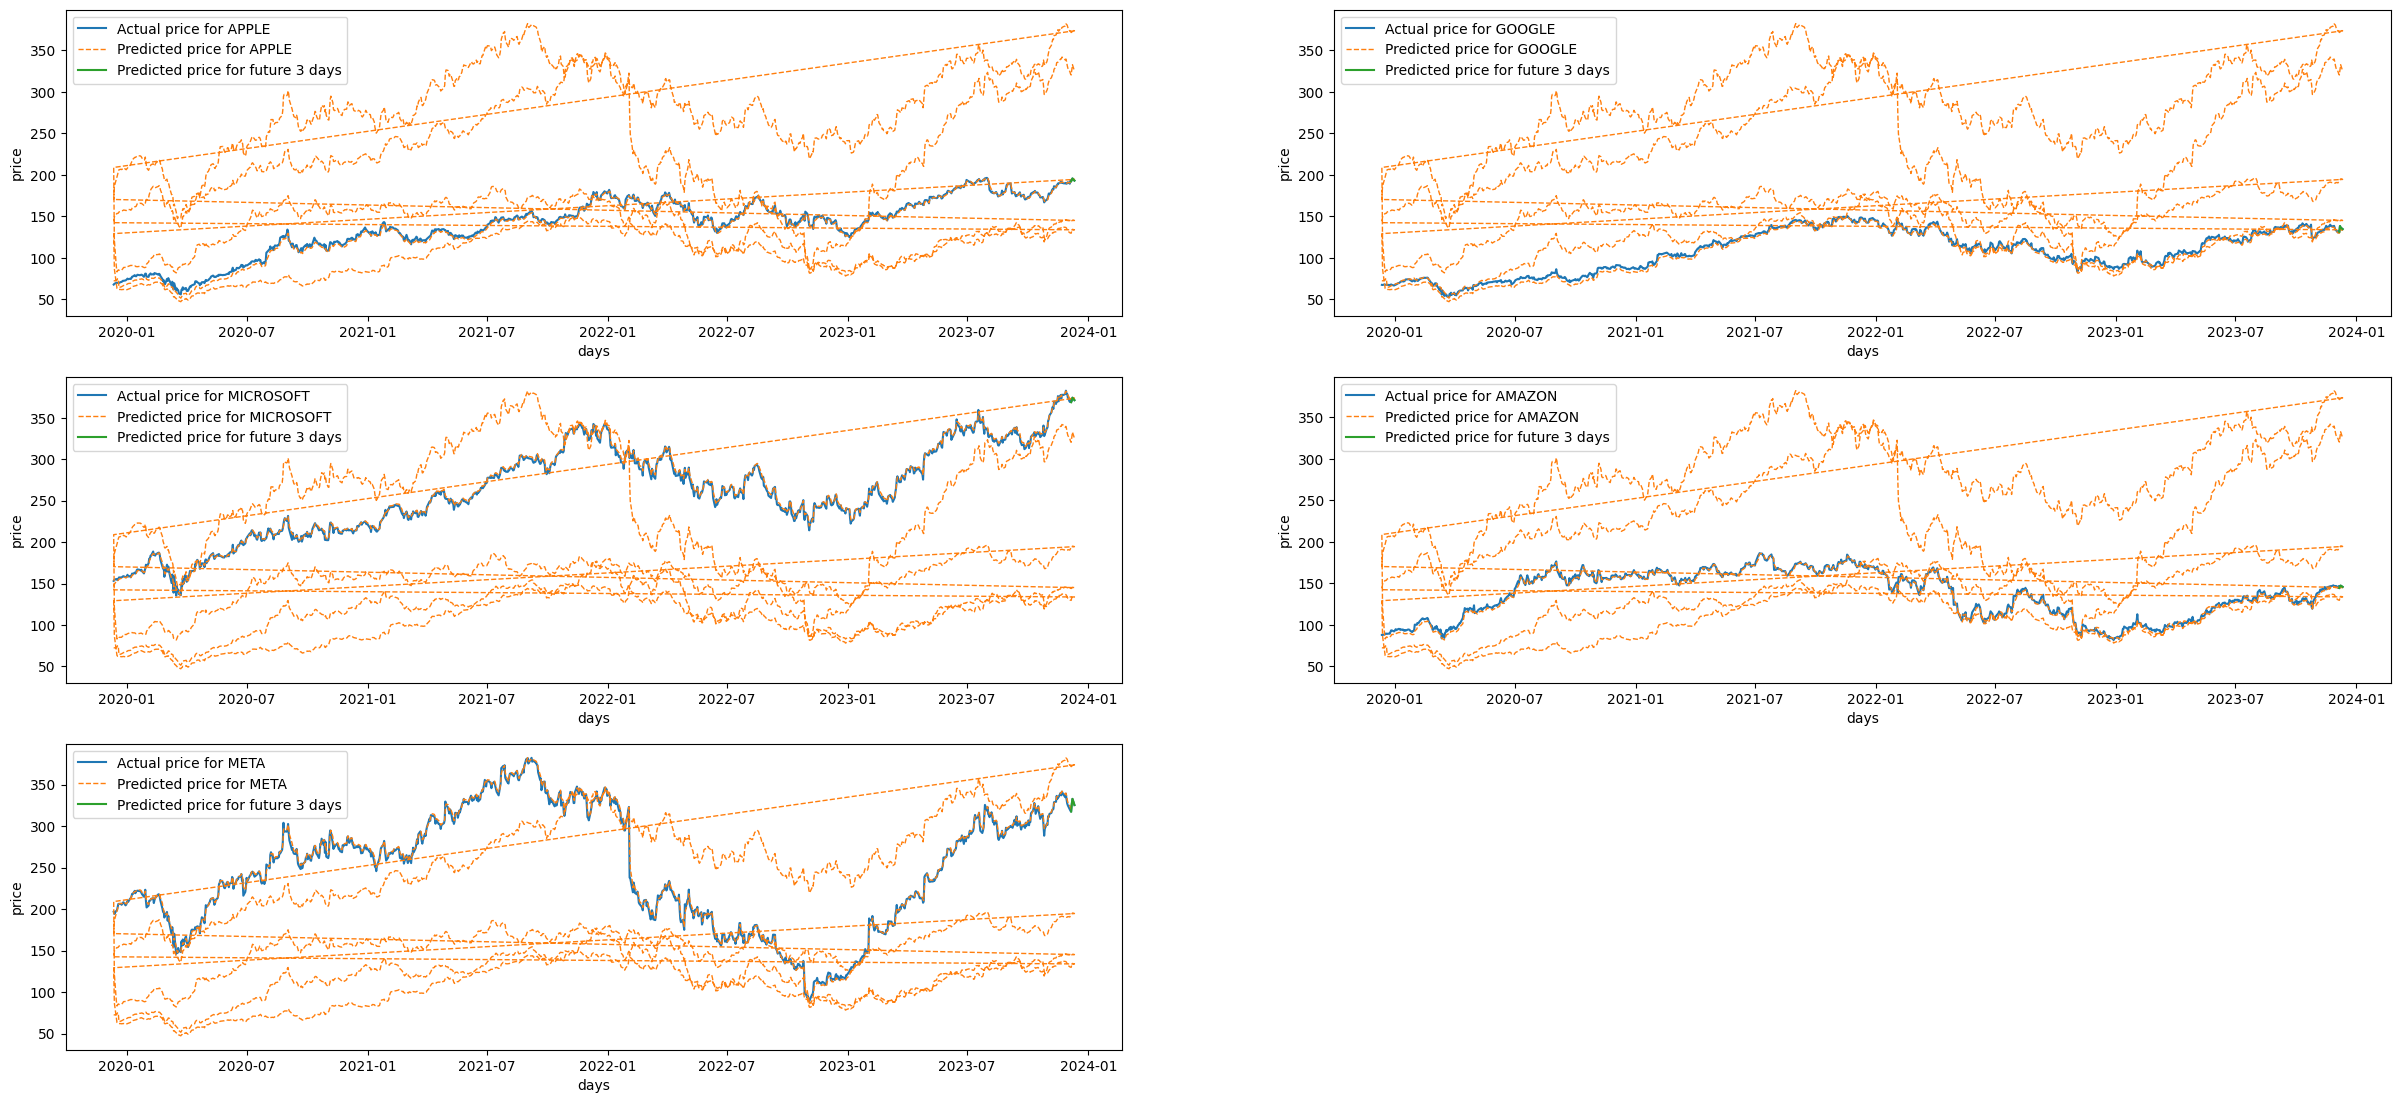

In [24]:
plt.figure(figsize=(30, 8))
plt.subplots_adjust(top=2.5, bottom=1.2)

for i, company in enumerate(company_ticker, 1):
  plt.subplot(3, 2, i)

  plt.plot(company['Close'])
  plt.plot(copy_df['predicted_close'], linewidth=1, linestyle='dashed')
  plt.plot(company['Close'][-150:].tail(4))
  plt.xlabel('days')
  plt.ylabel('price')
  plt.legend([f'Actual price for {company_name[i-1]}',
            f'Predicted price for {company_name[i-1]}',
            f'Predicted price for future 3 days'])

In [19]:
for i, company in enumerate(company_ticker, 1):
  if bool(predictions) == True and len(predictions) > 0:
    predictions_list = ['$' + str(d) for d in predictions]
    predictions_str = ', '.join(predictions_list)
    message = f'{company_name[i-1]} prediction for upcoming 3 days ({predictions_str})'

    print(message)

APPLE prediction for upcoming 3 days ($243.93, $239.16, $242.8)
GOOGLE prediction for upcoming 3 days ($243.93, $239.16, $242.8)
MICROSOFT prediction for upcoming 3 days ($243.93, $239.16, $242.8)
AMAZON prediction for upcoming 3 days ($243.93, $239.16, $242.8)
META prediction for upcoming 3 days ($243.93, $239.16, $242.8)
TESLA prediction for upcoming 3 days ($243.93, $239.16, $242.8)


In [20]:
date_now

[243.93, '2023-12-12', 0, 0]